# mise en place du modèle keypoint

In [1]:
import numpy as np


SyntaxError: invalid syntax (1597818673.py, line 2)

## video to gif 

In [1]:
! pip install opencv-python

In [4]:
import cv2
# turn images into frame

import glob
from PIL import Image, ImageDraw

In [4]:
api_file_path = './data/walking/v_walk_dog_01/v_walk_dog_01_01.avi'
# ff = FFmpeg(inputs={api_file_path: None},
# outputs={'walk_dog_01_01.mp4': None})
# ff.cmd

In [5]:
def getFrame(sec,vidcap,count):

    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("./data/images/"+str(count)+".jpg", image)
    return hasFrames

In [6]:
def video_to_gif(file_path,gif_name, sec = 0,frameRate = 0.5,count=1): 
    '''turn video into gif 
    args : 
    -sec : ??
    '''
    vidcap = cv2.VideoCapture(file_path)
    count=1
    success = getFrame(sec,vidcap,count)
    still_reading, image = vidcap.read()
    while still_reading:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success = getFrame(sec,vidcap,count)
        still_reading, image = vidcap.read()
    
    # Create the frames

    frames = []
    imgs = glob.glob(f"./data/images/*.jpg")
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)
    # Save into a GIF file that loops forever
    frames[0].save(f'./data/Gif/{gif_name}.gif', format='GIF',append_images=frames[1:],
                   save_all=True,duration=400, loop=0)
    print(frames.type)
    
    return Image.open(f'./data/Gif/{gif_name}.gif')

In [91]:
video_to_gif('./data/test_keypoint_v1.mov','gif_try4')

AttributeError: 'list' object has no attribute 'type'

In [5]:
# split the video into images

vidcap = cv2.VideoCapture(api_file_path)


def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("./data/images/"+str(count)+".jpg", image)
    return hasFrames
sec = 0
frameRate = 0.5
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

# Create the frames

frames = []
imgs = glob.glob("./data/images/*.jpg")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)



# Save into a GIF file that loops forever
frames[0].save('./data/Gif/gif_dog1.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

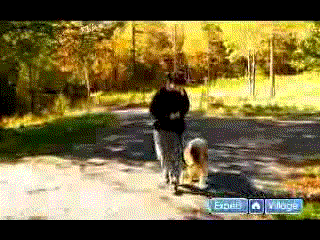

In [10]:
Image.open('./data/Gif/gif_dog1.gif')

### __TO DO__
 
  * faire un module - video_to_gif
  * avec création de la variable GIF a récupérer
  * l'input sera la video user
  * check le type potentiellement reframe a faire

## modèle 

In [9]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs


### imports

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

### utils to draw keypoints prediction on image

In [30]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
    """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted."""
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
        kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
        keypoints_all.append(kpts_above_thresh_absolute)

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
              if (kpts_scores[edge_pair[0]] > keypoint_threshold and
              kpts_scores[edge_pair[1]] > keypoint_threshold):
                x_start = kpts_absolute_xy[edge_pair[0], 0]
                y_start = kpts_absolute_xy[edge_pair[0], 1]
                x_end = kpts_absolute_xy[edge_pair[1], 0]
                y_end = kpts_absolute_xy[edge_pair[1], 1]
                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                edge_colors.append(color)
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))

    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    
    print(f'keypoints_xy.shape{keypoints_xy.shape}')
    print(f'edges_xy.shape{edges_xy.shape}')
    return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
    """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions. """
    height, width, channel = image.shape
    print(f'image shape: {image.shape}')
    print(f'keypoint shape : {keypoints_with_scores.shape}')
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    print(f'fig : {fig}' )
    plt.show()
    # To remove the huge white borders
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle='solid')
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    (keypoint_locs, keypoint_edges,edge_colors) = \
    _keypoints_and_edges_for_display(keypoints_with_scores, height, width)
    print(f'keypoint_locs.shape :{keypoint_locs.shape}')
    
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region['x_min'] * width, 0.0)
        ymin = max(crop_region['y_min'] * height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99) * width - xmin
        rec_height = min(crop_region['y_max'], 0.99) * height - ymin
        rect = patches.Rectangle((xmin,ymin),rec_width,rec_height,
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)


    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    print(image_from_plot.shape)
    print(len(image_from_plot))
    print(fig.canvas.get_width_height()[::-1])
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(image_from_plot, dsize=(output_image_width, output_image_height),
             interpolation=cv2.INTER_CUBIC)
    return image_from_plot

def to_gif(images, fps): # reuse this function in the package to switch iamge file list to gif
    """Converts image sequence (4D numpy array) to gif."""
    imageio.mimsave('./animation.gif', images, fps=fps)
    return embed.embed_file('./animation.gif')

def progress(value, max=100):
    return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>""".format(value=value, max=max))

### Model definition

In [10]:
model_name = "movenet_lightning"



if "movenet_lightning" in model_name: # use this one for now not until tuning or refining should we use thunder
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
else:
    raise ValueError("Unsupported model name: %s" % model_name)

def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

2022-03-02 21:58:20.287504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Try for single image

In [16]:
!curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent

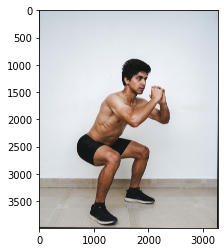

In [17]:
# Load the input image.
image_path = 'input_image.jpeg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
plt.imshow(image)

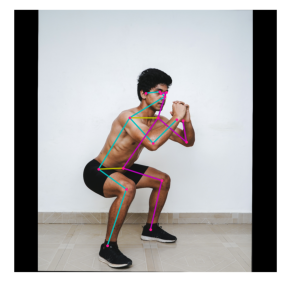

In [18]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

### crop the video sequence

In [14]:
# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
    """Defines the default crop region.

      The function provides the initial crop region (pads the full image from both
      sides to make it a square image) when the algorithm cannot reliably determine
      the crop region from the previous frame.
      """
    if image_width > image_height:
        box_height = image_width / image_height
        box_width = 1.0
        y_min = (image_height / 2 - image_width / 2) / image_height
        x_min = 0.0
    else:
        box_height = 1.0
        box_width = image_height / image_width
        y_min = 0.0
        x_min = (image_width / 2 - image_height / 2) / image_width

    return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
    }

def torso_visible(keypoints):
    """Checks whether there are enough torso keypoints.

    This function checks whether the model is confident at predicting one of the
    shoulders/hips which is required to determine a good crop region.
    """
    return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(keypoints, target_keypoints, center_y, center_x):
    """Calculates the maximum distance from each keypoints to the center location.

    The function returns the maximum distances from the two sets of keypoints:
    full 17 keypoints and 4 torso keypoints. The returned information will be
    used to determine the crop size. See determineCropRegion for more detail.
    """
    torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    max_torso_yrange = 0.0
    max_torso_xrange = 0.0
    for joint in torso_joints:
        dist_y = abs(center_y - target_keypoints[joint][0])
        dist_x = abs(center_x - target_keypoints[joint][1])
        if dist_y > max_torso_yrange:
            max_torso_yrange = dist_y
        if dist_x > max_torso_xrange:
            max_torso_xrange = dist_x

    max_body_yrange = 0.0
    max_body_xrange = 0.0
    for joint in KEYPOINT_DICT.keys():
        if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
              continue
        dist_y = abs(center_y - target_keypoints[joint][0]);
        dist_x = abs(center_x - target_keypoints[joint][1]);
        if dist_y > max_body_yrange:
              max_body_yrange = dist_y

        if dist_x > max_body_xrange:
              max_body_xrange = dist_x

    return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
    """Determines the region to crop the image for the model to run inference on.

      The algorithm uses the detected joints from the previous frame to estimate
      the square region that encloses the full body of the target person and
      centers at the midpoint of two hip joints. The crop size is determined by
      the distances between each joints and the center point.
      When the model is not confident with the four torso joint predictions, the
      function returns a default crop which is the full image padded to square.
      """
    target_keypoints = {}
    for joint in KEYPOINT_DICT.keys():
        target_keypoints[joint] = [
          keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
          keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
        ]

    if torso_visible(keypoints):
        center_y = (target_keypoints['left_hip'][0] +
                    target_keypoints['right_hip'][0]) / 2;
        center_x = (target_keypoints['left_hip'][1] +
                    target_keypoints['right_hip'][1]) / 2;

        (max_torso_yrange, max_torso_xrange,max_body_yrange, max_body_xrange) = \
        determine_torso_and_body_range(keypoints, target_keypoints, center_y, center_x)

        crop_length_half = np.amax(
            [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
              max_body_yrange * 1.2, max_body_xrange * 1.2])

        tmp = np.array(
            [center_x, image_width - center_x, center_y, image_height - center_y])
        crop_length_half = np.amin(
            [crop_length_half, np.amax(tmp)]);

        crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

        if crop_length_half > max(image_width, image_height) / 2:
              return init_crop_region(image_height, image_width)
        else:
              crop_length = crop_length_half * 2;
        return {
            'y_min': crop_corner[0] / image_height,
            'x_min': crop_corner[1] / image_width,
            'y_max': (crop_corner[0] + crop_length) / image_height,
            'x_max': (crop_corner[1] + crop_length) / image_width,
            'height': (crop_corner[0] + crop_length) / image_height -
                crop_corner[0] / image_height,
            'width': (crop_corner[1] + crop_length) / image_width -
                crop_corner[1] / image_width
          }
    else:
        return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
    """Crops and resize the image to prepare for the model input."""
    boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
    output_image = tf.image.crop_and_resize(image, box_indices=[0], boxes=boxes, crop_size=crop_size)
    return output_image

def run_inference(movenet, image, crop_region, crop_size):
    """Runs model inferece on the cropped region.

    The function runs the model inference on the cropped region and updates the
    model output to the original image coordinate system.
    """
    image_height, image_width, _ = image.shape
    input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
      # Run model inference.
    keypoints_with_scores = movenet(input_image)
    # Update the coordinates.
    for idx in range(17):
        keypoints_with_scores[0, 0, idx, 0] = (
            crop_region['y_min'] * image_height +
            crop_region['height'] * image_height *
            keypoints_with_scores[0, 0, idx, 0]) / image_height
        keypoints_with_scores[0, 0, idx, 1] = (
            crop_region['x_min'] * image_width +
            crop_region['width'] * image_width *
            keypoints_with_scores[0, 0, idx, 1]) / image_width
    return keypoints_with_scores

### model inference try on gif

In [20]:
!wget -q -O dance.gif https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/dance_input.gif

In [21]:
# Load the input image.
image_path = 'dance.gif'
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)
image.shape

TensorShape([42, 338, 600, 3])

image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


AttributeError: 'Figure' object has no attribute 'figsize'

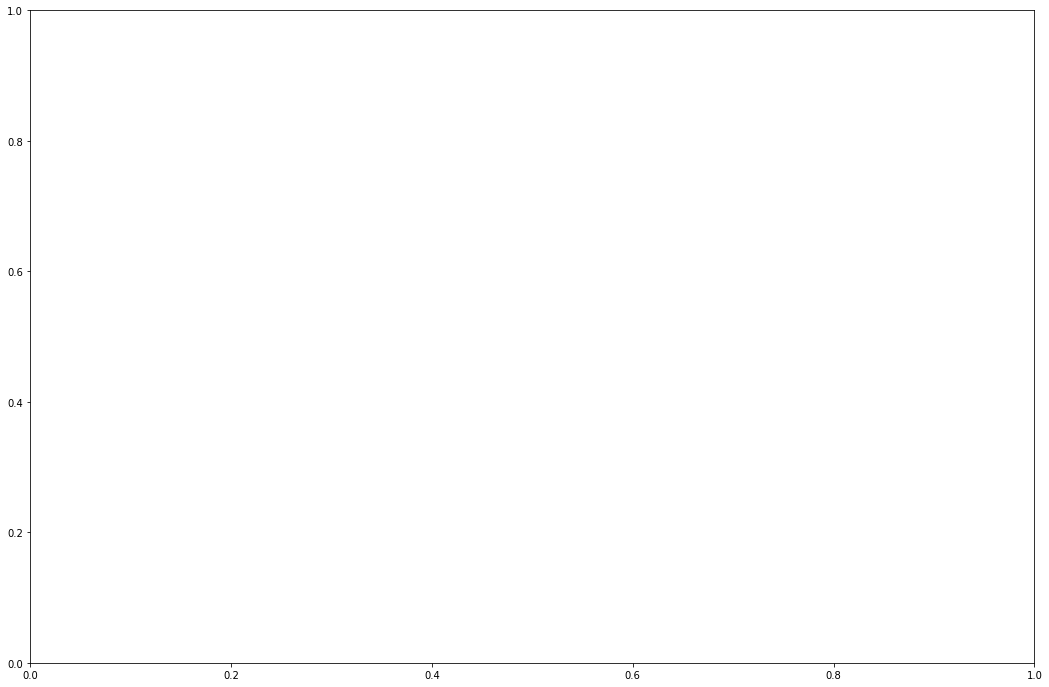

In [24]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)
keypoints_sequence = []
output_images = []

bar = display(progress(0, num_frames-1), display_id=True)

# code to run the model on each image 
for frame_idx in range(num_frames):
    keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size]) # run model for image
    
    output_images.append(draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300)) # add image to image sequence
    
    keypoints_sequence.append(keypoints_with_scores)
    
    crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
    bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
to_gif(output, fps=10)

In [24]:
output_images

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

## essai vidéo maison

### prepare the output 

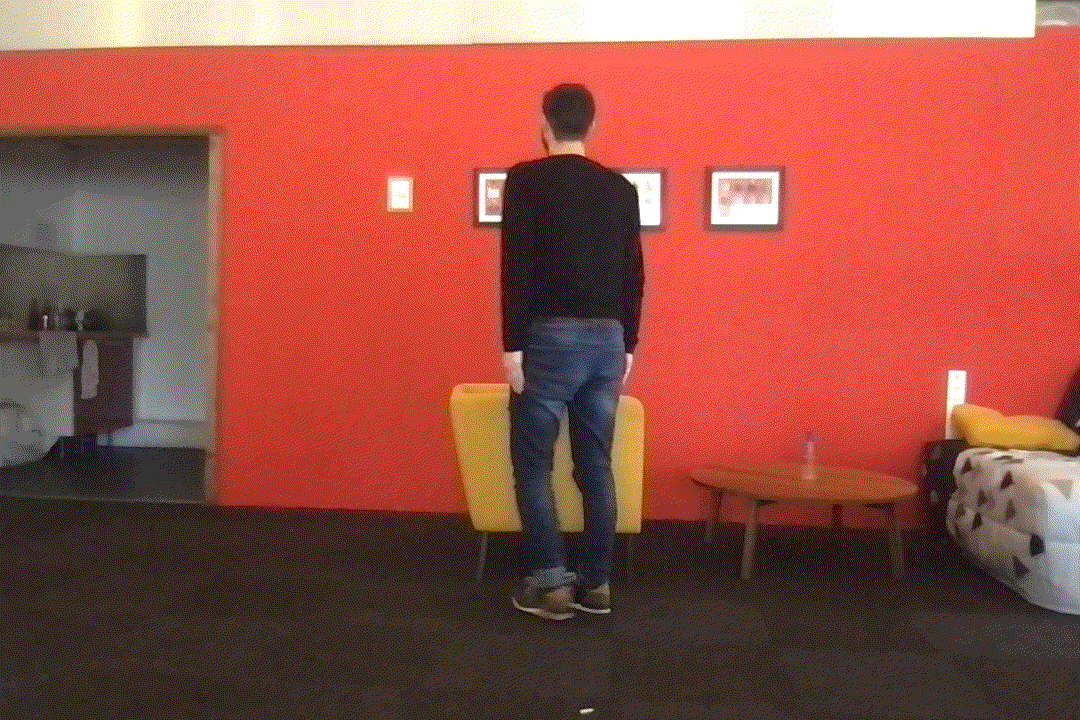

In [11]:
Image.open('./data/Gif/gif_try4.gif')

In [12]:
# Load the input image.
image_path = './data/Gif/gif_try4.gif'
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)
image.shape

TensorShape([20, 720, 1080, 3])

(20, 720, 1080, 3)
(720, 1080, 3)


(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


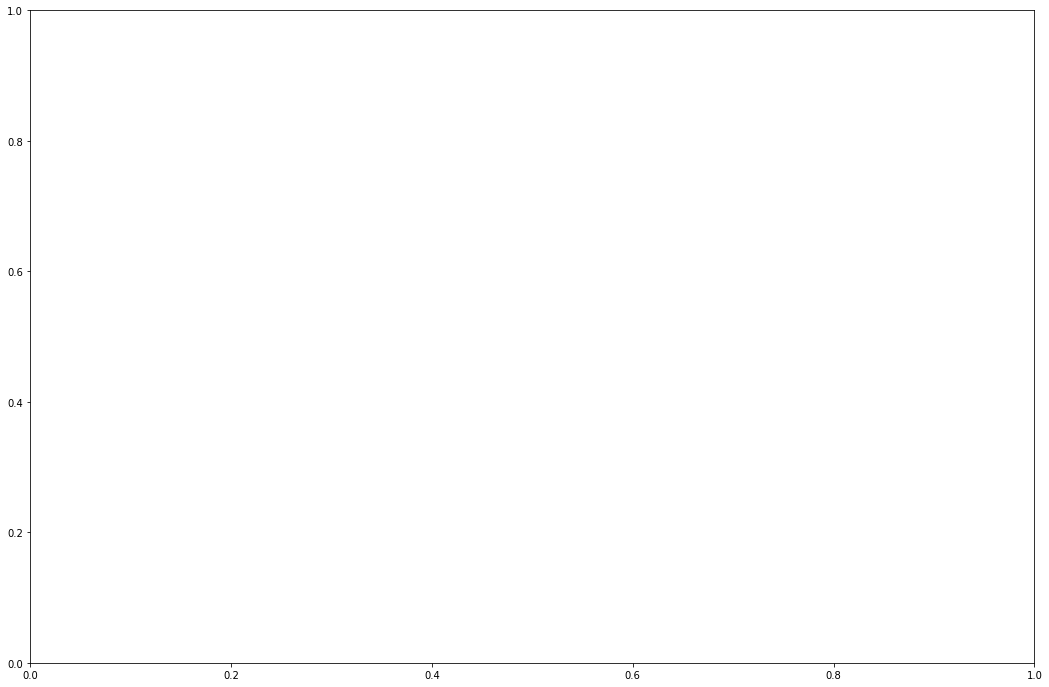

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


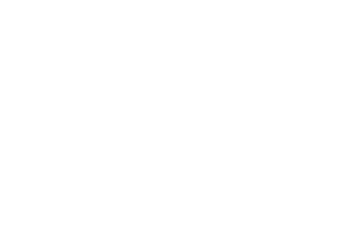

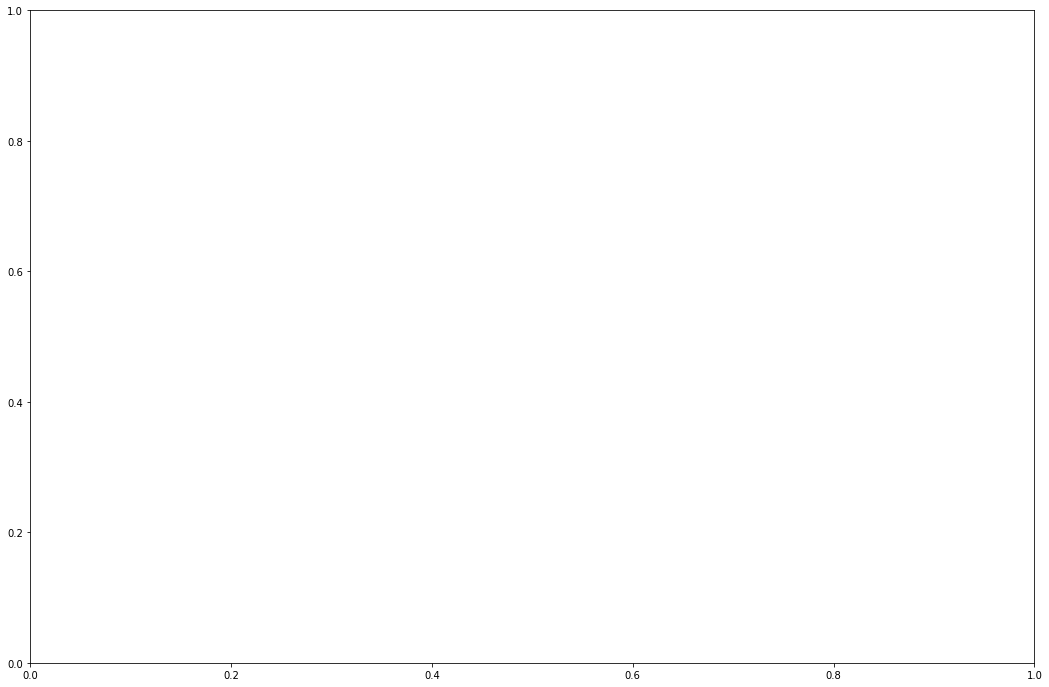

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


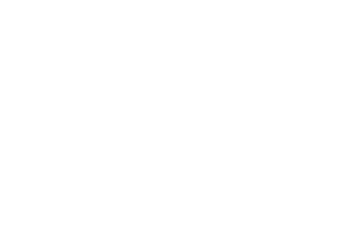

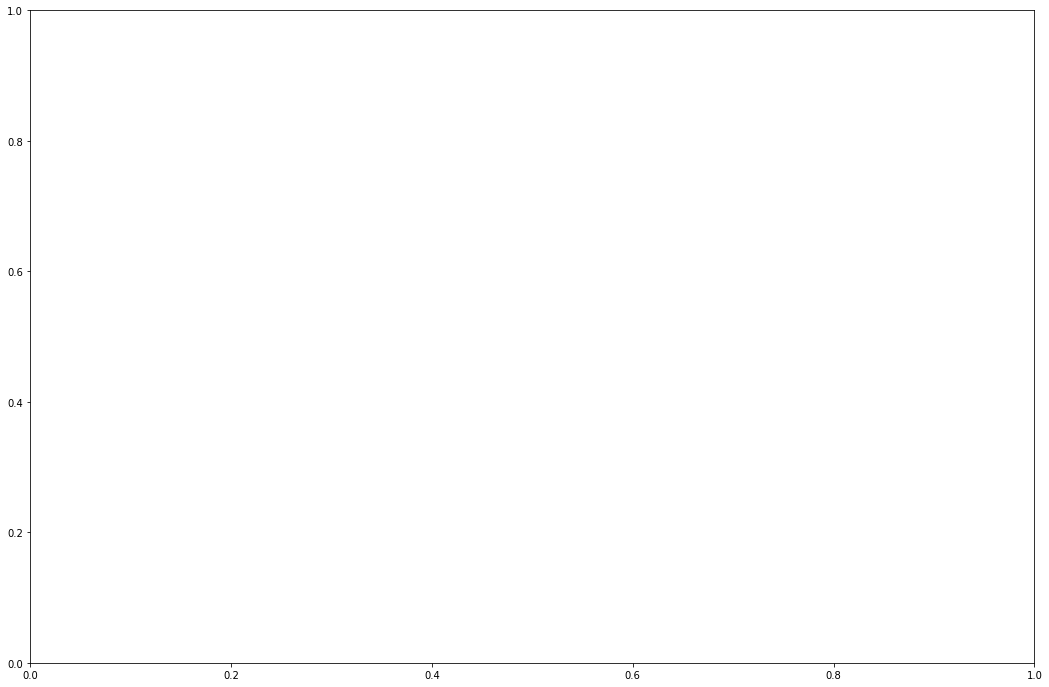

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


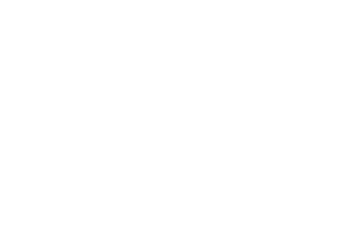

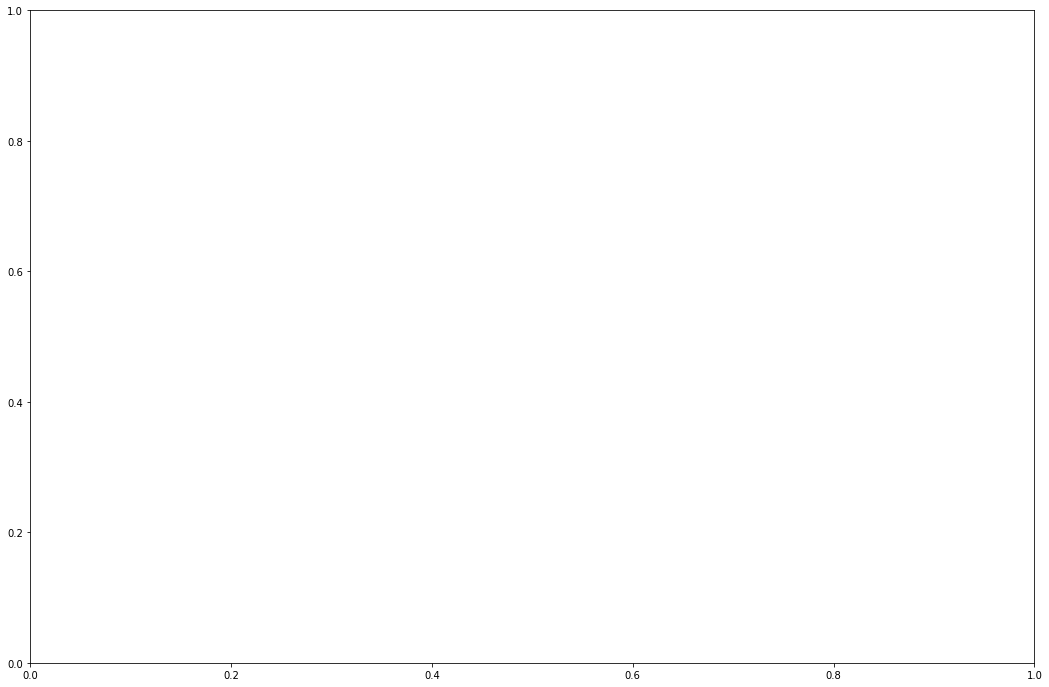

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


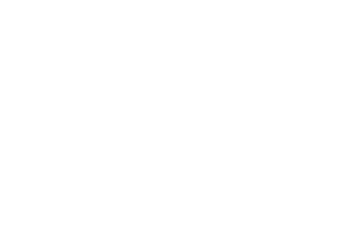

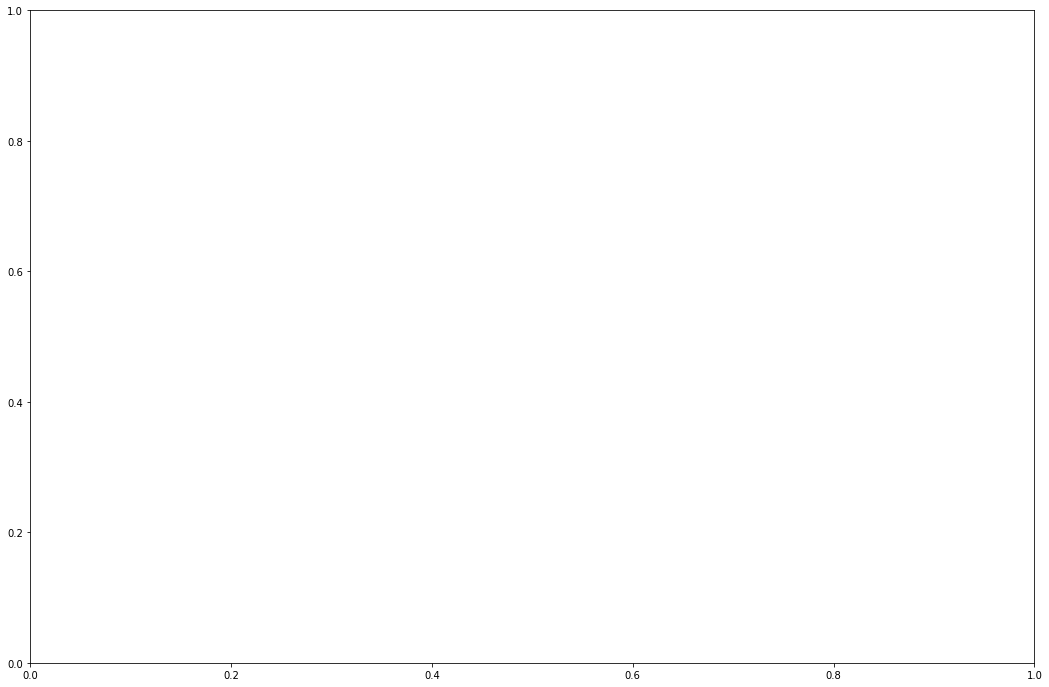

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


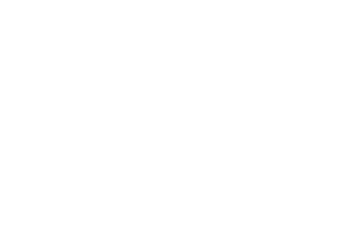

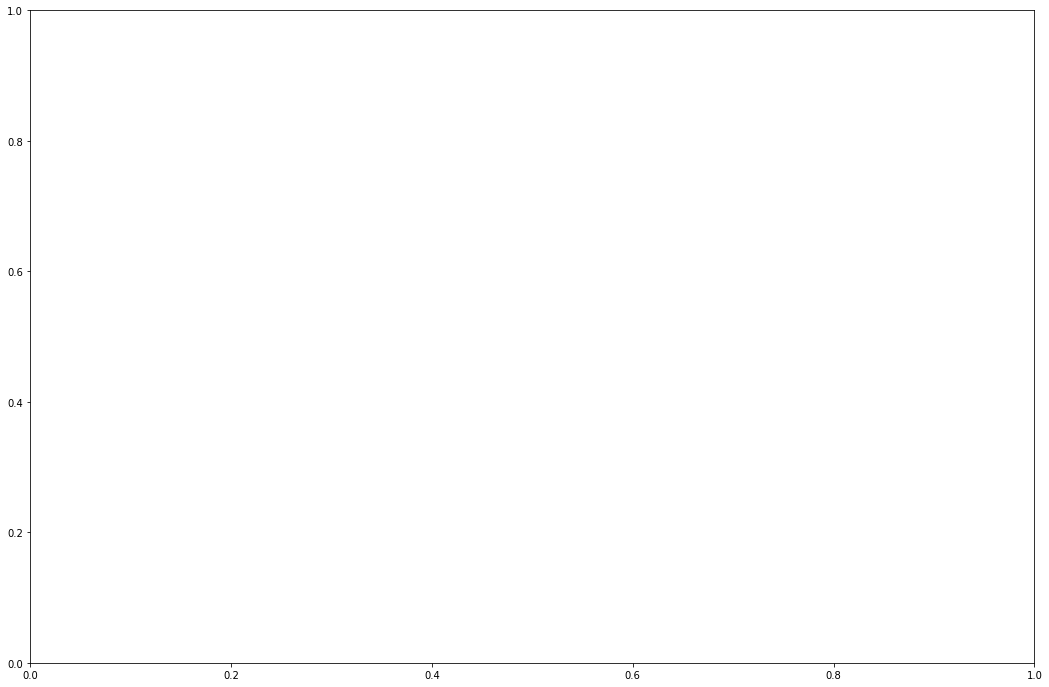

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


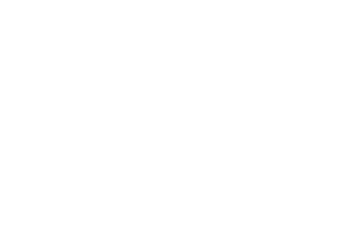

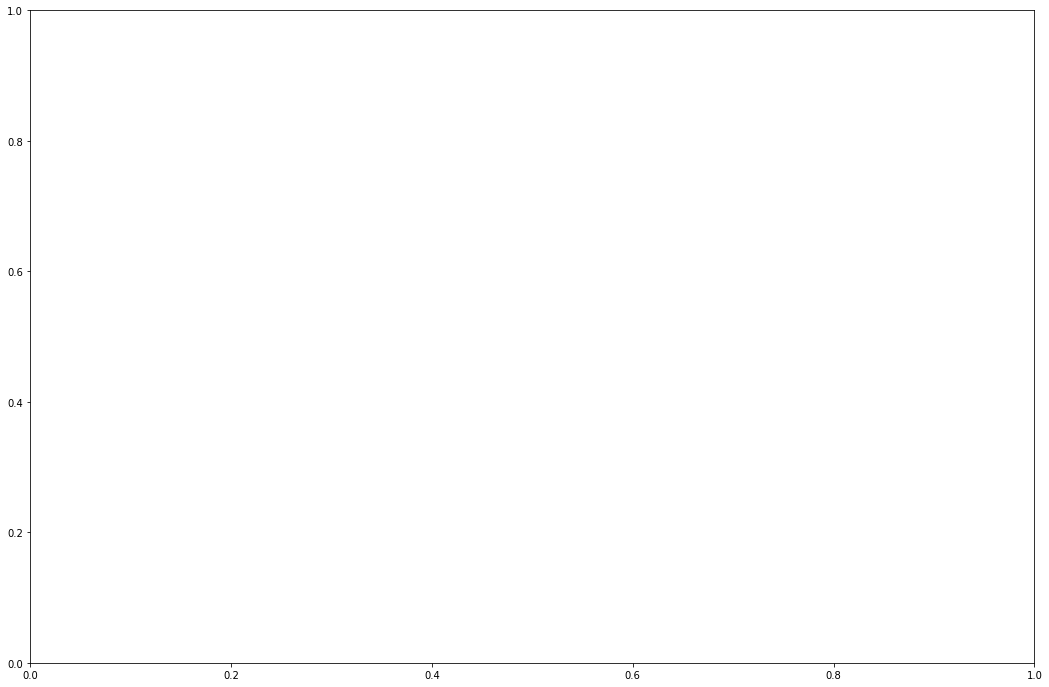

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


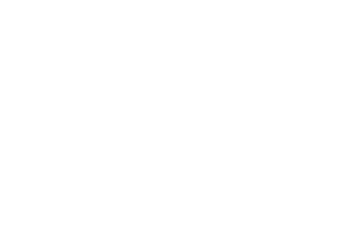

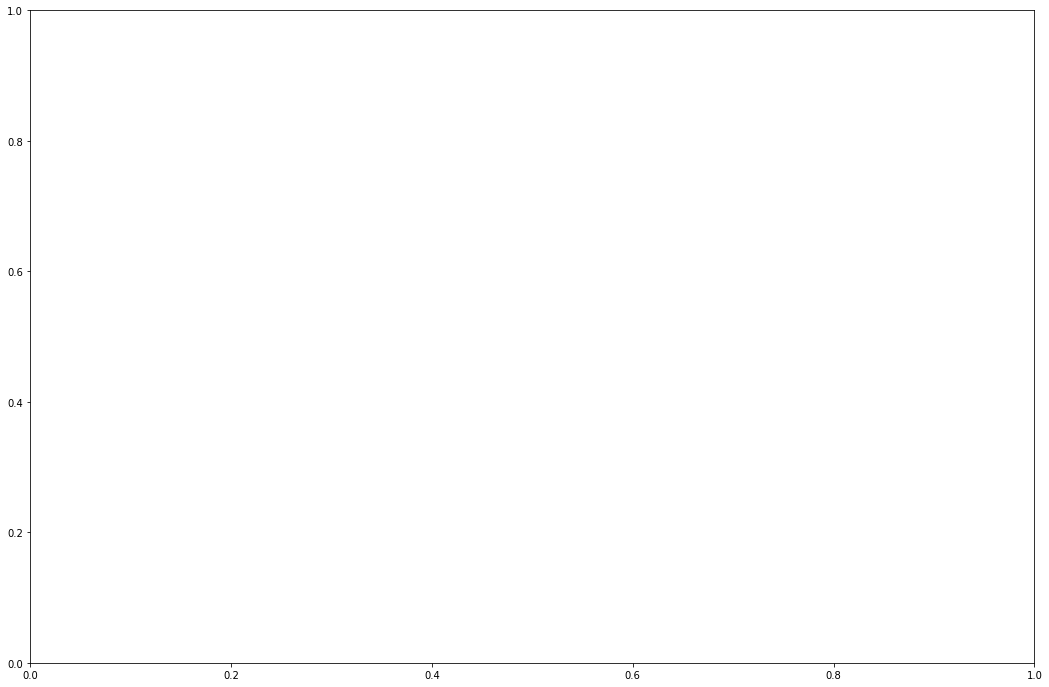

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


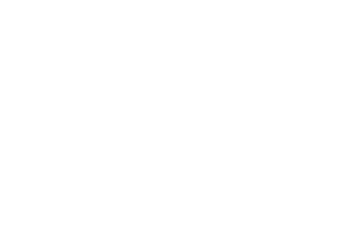

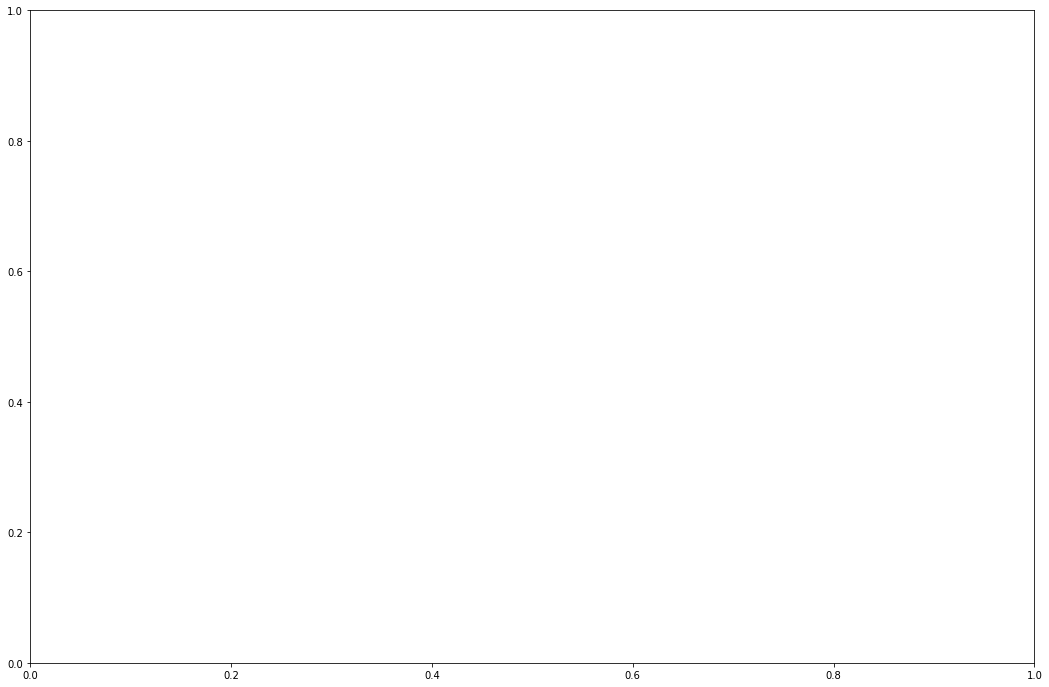

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


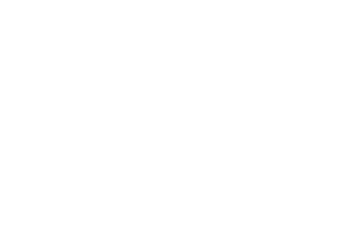

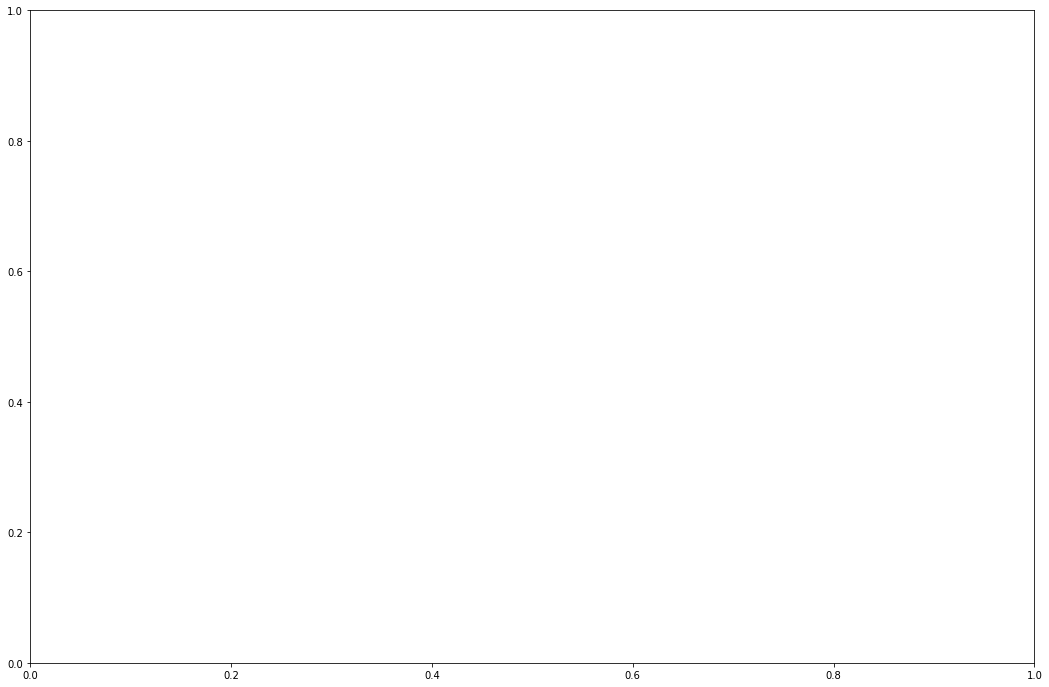

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


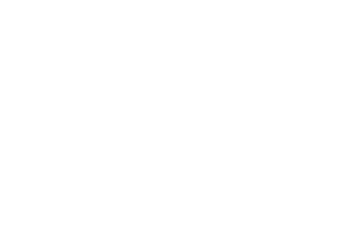

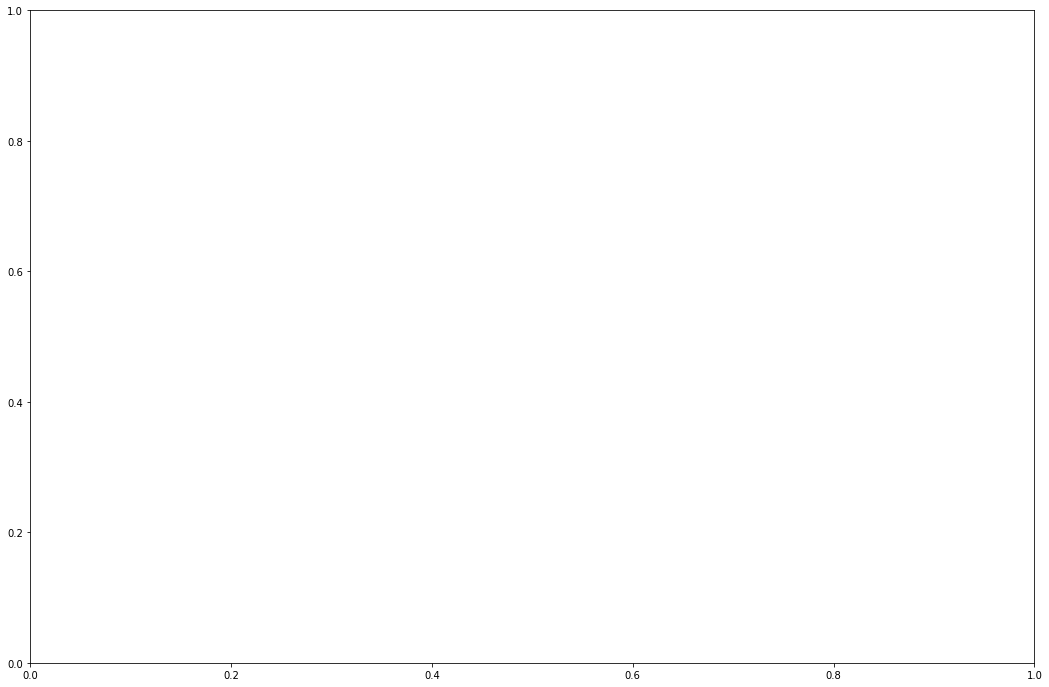

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


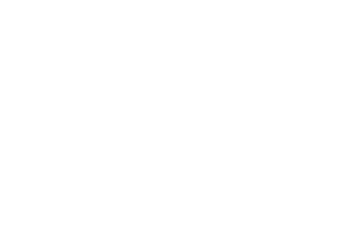

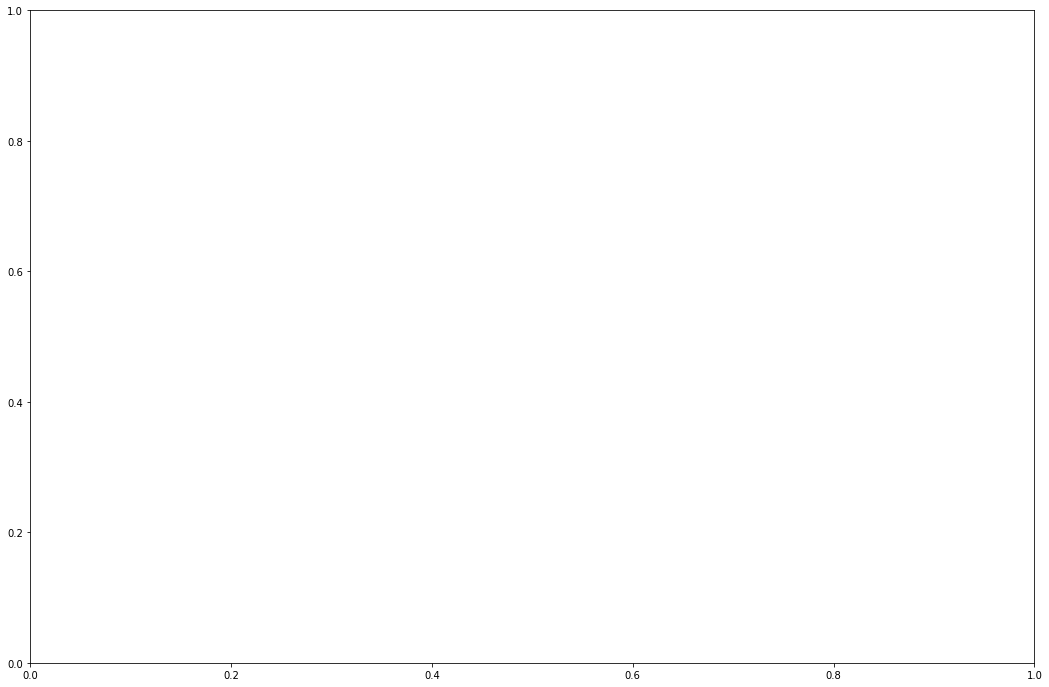

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


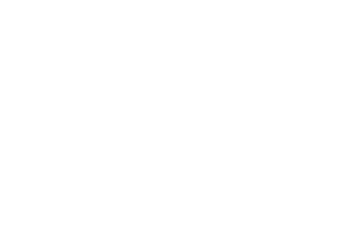

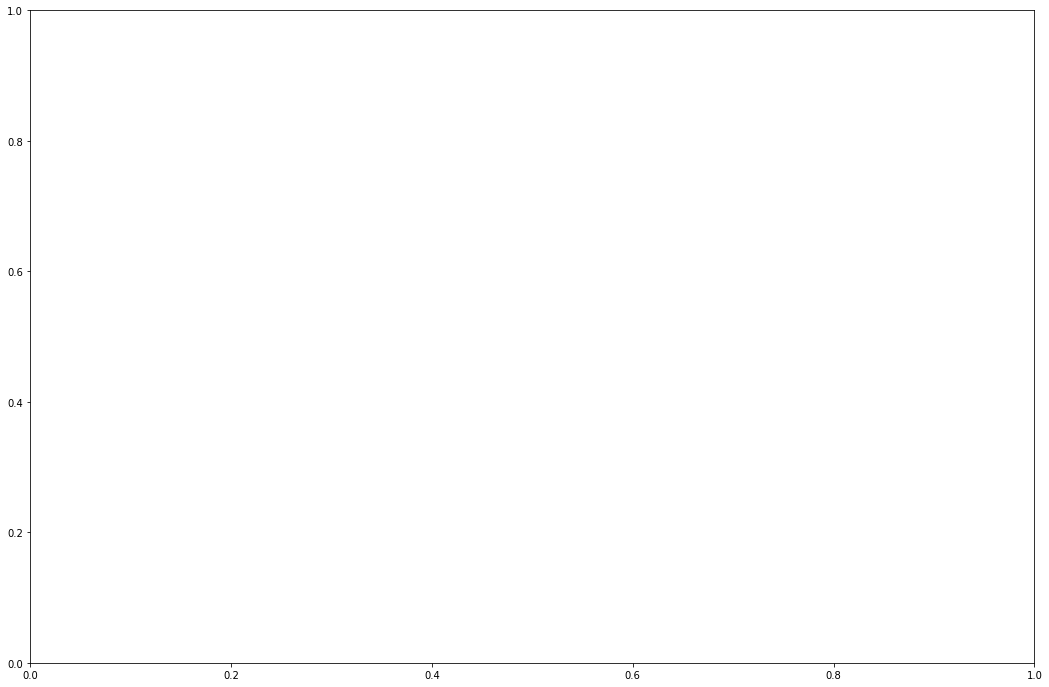

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


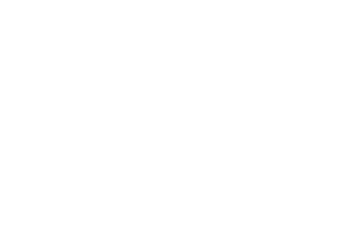

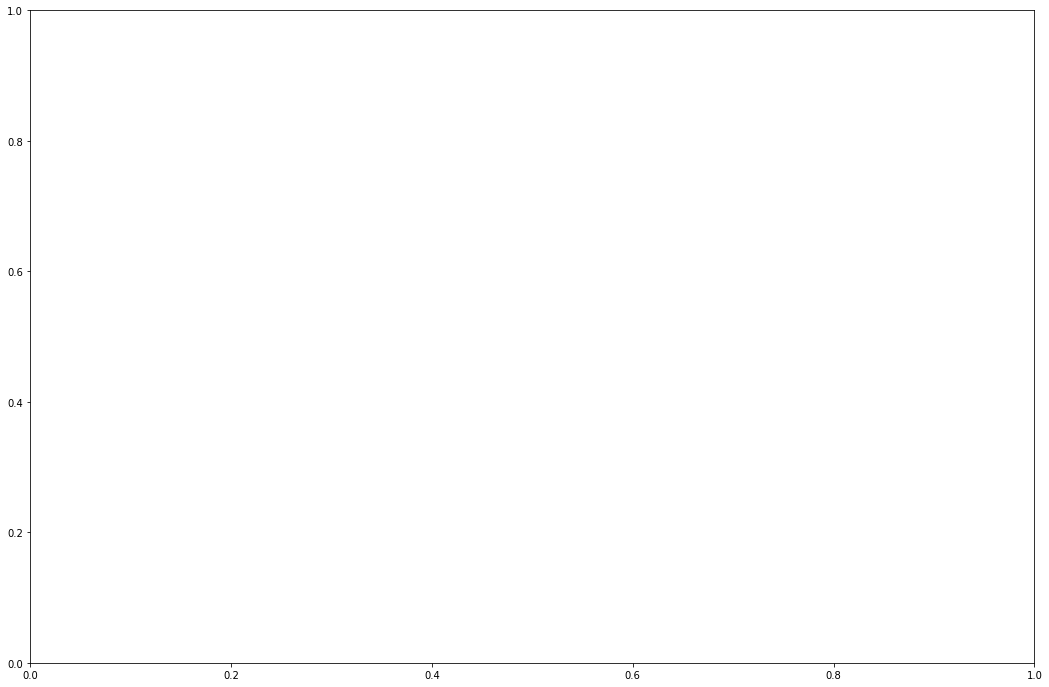

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


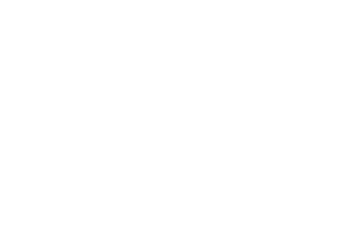

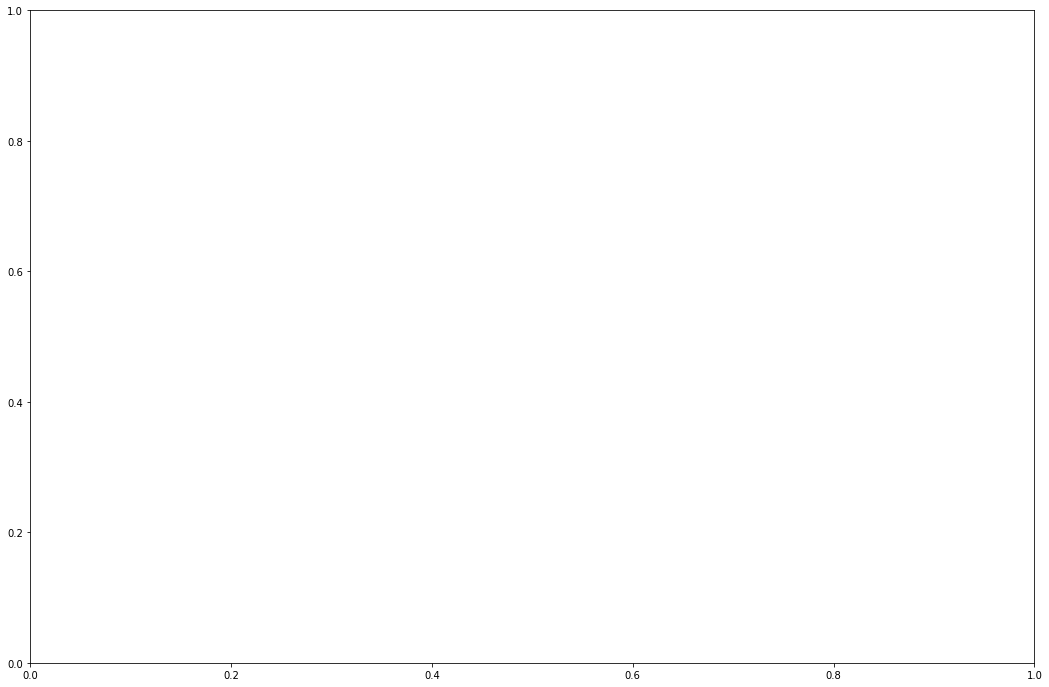

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


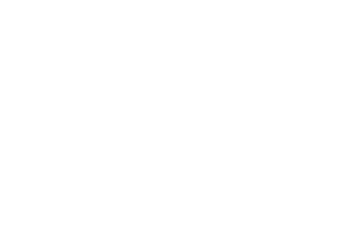

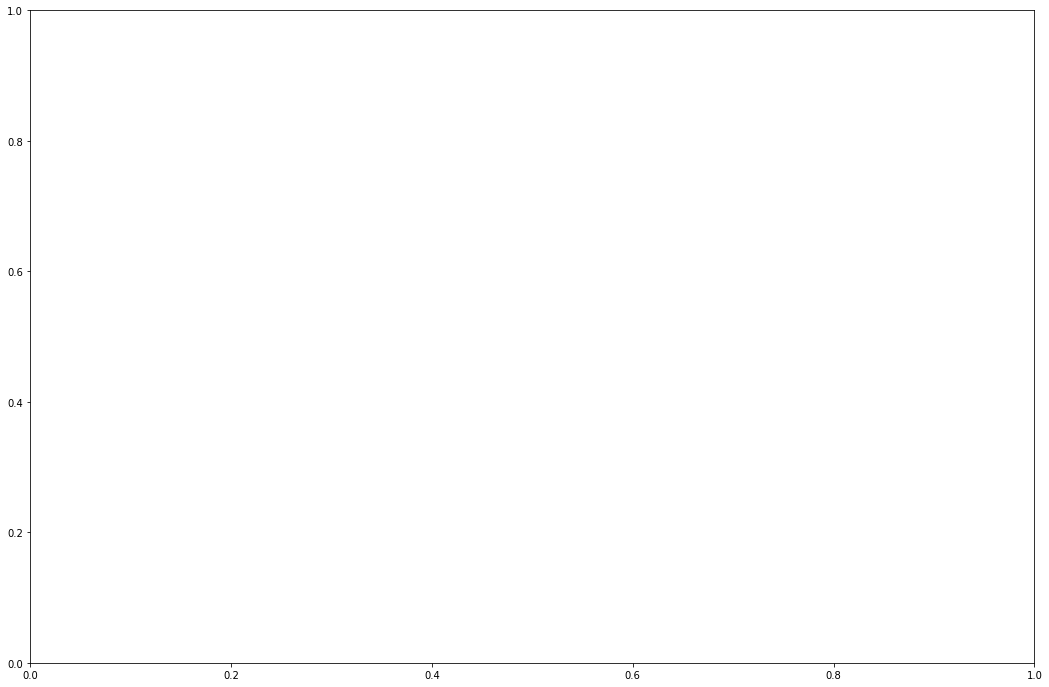

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


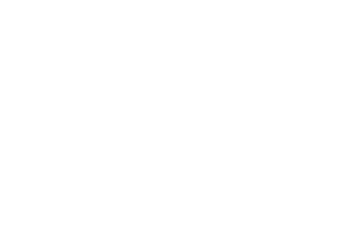

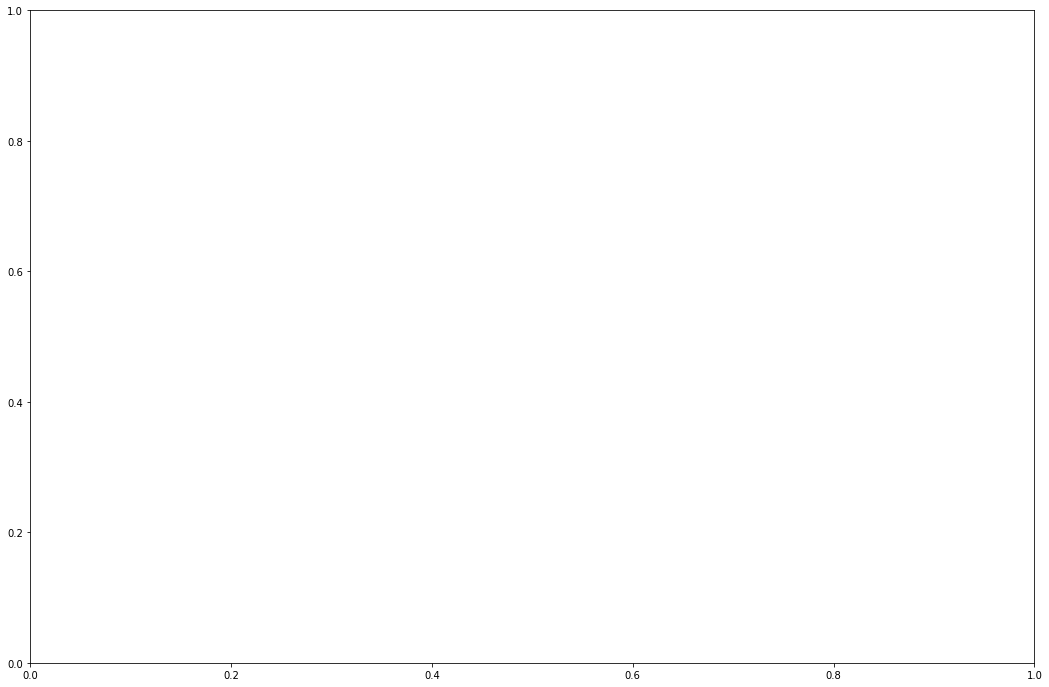

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


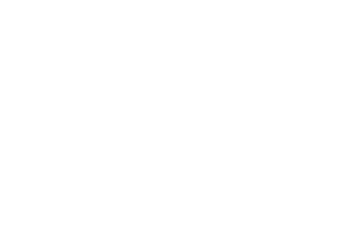

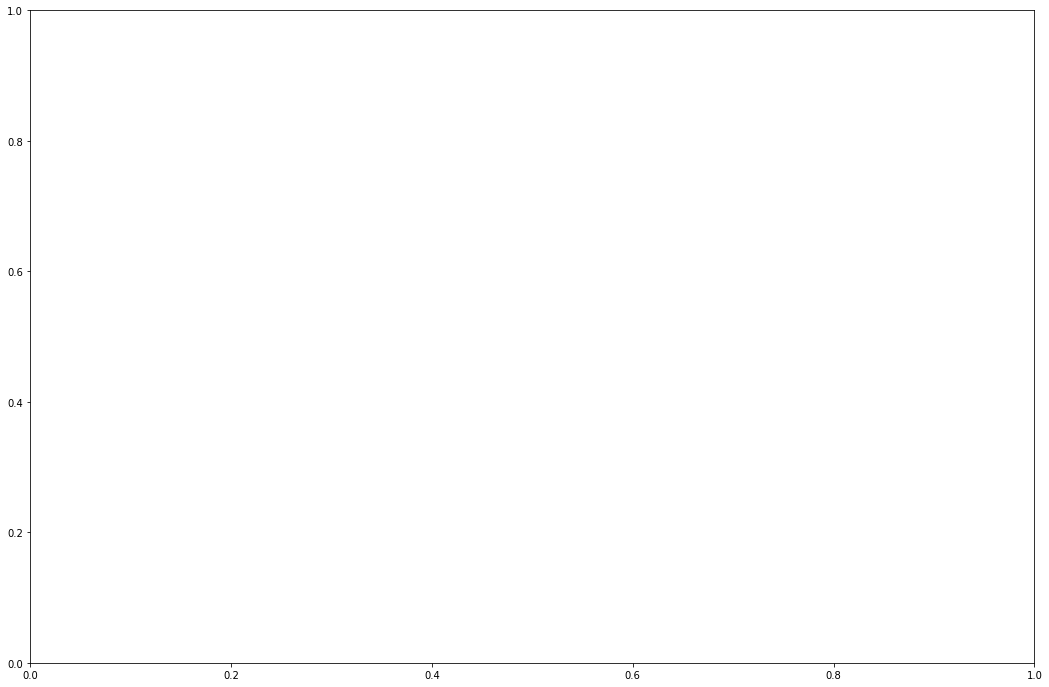

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


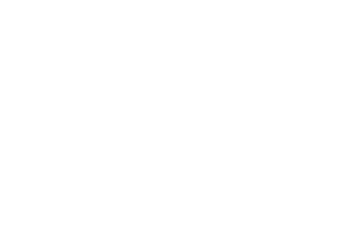

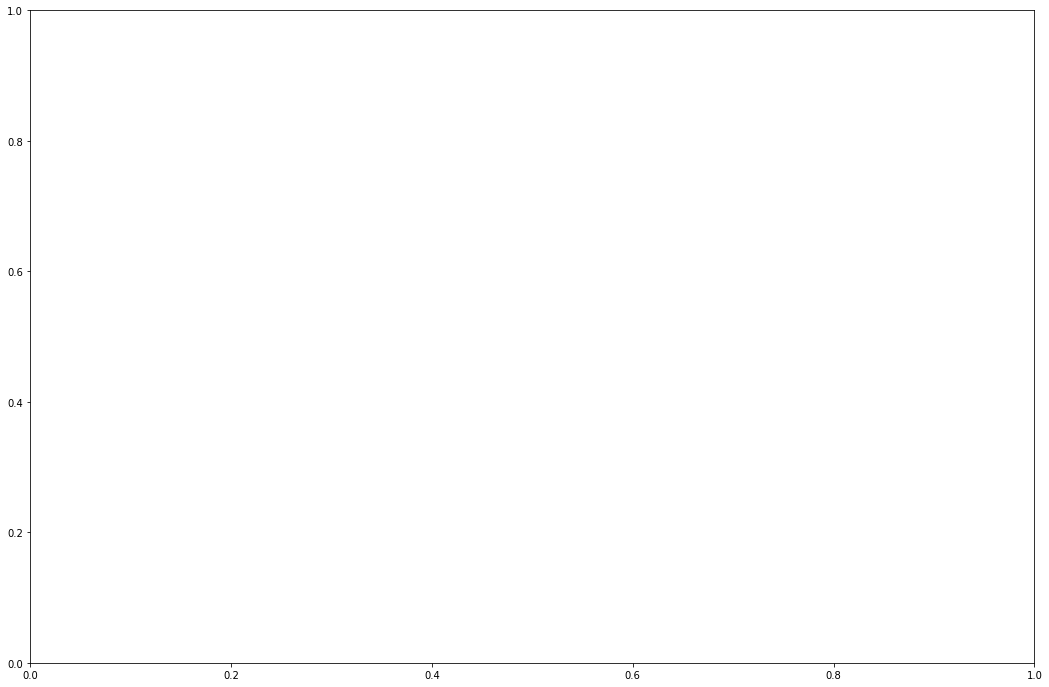

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)
(720, 1080, 3)
image shape: (720, 1080, 3)
keypoint shape : (1, 1, 17, 3)
fig : Figure(1296x864)


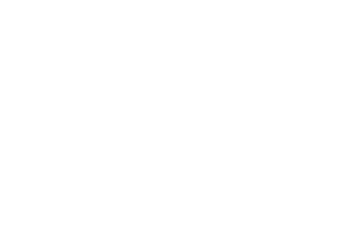

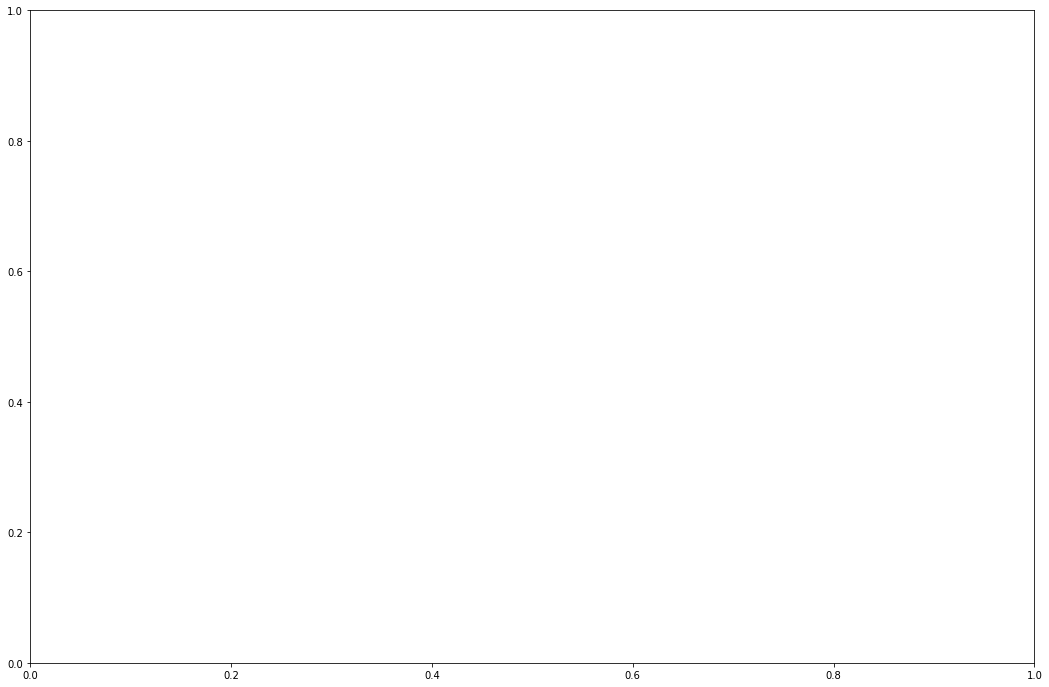

keypoints_xy.shape(17, 2)
edges_xy.shape(18, 2, 2)
keypoint_locs.shape :(17, 2)
None
(3359232,)
3359232
(864, 1296)



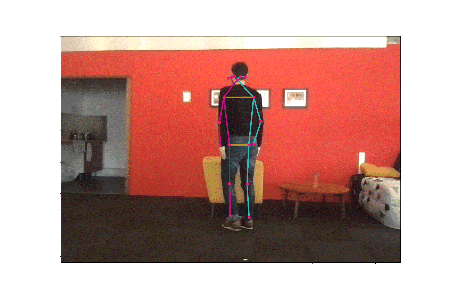

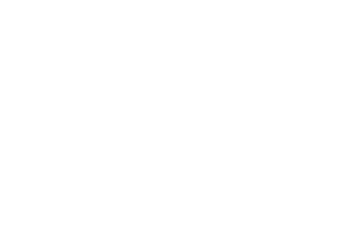

In [33]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
print(image.shape)
print(image[frame_idx, :, :, :].numpy().astype(np.int32).shape)
crop_region = init_crop_region(image_height, image_width)
keypoints_sequence = []
output_images = []

bar = display(progress(0, num_frames-1), display_id=True)

# code to run the model on each image 
for frame_idx in range(num_frames):
    keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size]) # run model for image
    print(image[frame_idx, :, :, :].numpy().astype(np.int32).shape)
    output_images.append(draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300)) # add image to image sequence
    
    keypoints_sequence.append(keypoints_with_scores)
    
    crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
    bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
output_gif = to_gif(output, fps=10)
output_gif

In [95]:
list(output_images[0][0])

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [100]:
output.shape


(22, 300, 450, 3)

In [92]:
np.array(keypoints_sequence).shape

(42, 1, 1, 17, 3)